### Linear Regression the Bayesian Way

**Note that is still work in progress**

This is a simple notebook demonstrating two approaches to fitting Bayesian Linear Regression. We use a model, where we assume that the variance $\sigma^2$ of the data generating process is known.


* The Brute Force evaluation of the unnormalized posterior at all positions 
    + this approch is simular to chapter 7, but now with two Gaussian prios on the weights 
* Variational Approch
* The Bayes by Backprop approach.

In [43]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  False


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0-rc0
TF  Version 2.0.0-rc0


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)
%matplotlib inline
plt.style.use('default') # No background 
plt.rcParams.update({'font.size': 15}) # Large Fonts

### Creation of data

Creation of some data and definition of parameters

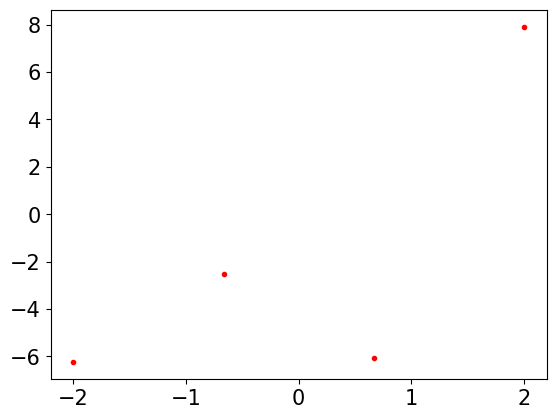

In [46]:
np.random.seed(2)
num = 4
#nbins = 30 #used to create the plots for the book (takes quite some time)
nbins = 10
bmin=-10;bmax=8
amin=-3;amax=8
xmin = -5;xmax = +5;ymin=-40;ymax=40;
nbins_c=30; sigma=3
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,sigma,num) 

plt.scatter(x,y, marker='.', color='r')
plt.show()

#d = np.transpose(np.vstack((x[:,0],y)))
#np.savetxt('data_blr_{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e');     

### Fitting a linear model (Max Likelihood)
First fit a linear model (corresponding to the maximum likelihood approach)

In [47]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml)

Coefficients a_ml:  2.9205102572725816 Coefficients b_ml -1.726712471421449


## Bayesian linear regression
We now assume the following posterior knowlegde 

1. We assume that we know the noise on the data. We can drop this assumption, however, here we want to show the different ways to fit Bayesian models. Estimating $\sigma$ is a bit more complicated, since we cannot assume a Gaussian prior. 

2. We assume the following priors on the weight $a \thicksim N(0,1)$ and intercept $b \thicksim N(0,1)$

### Brute Force Bayesian

$$
    P(w|d) \thicksim \frac{P(d|w) P(w)}{P(d)} 
$$

We can calculate $P(d|w) P(w) =: \tt{unnormalized{\_}posterior}$ quite easily. For convenience we calculate the log.

In [48]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
ytensor = y.reshape([len(y),1]) #A
def log_post_unnorm(w): #B
    rv_a = tfd.Normal(loc=0., scale=1.) #C 
    rv_b = tfd.Normal(loc=0., scale=1.) #C    
    y_prob = tfd.Independent( #D
        tfd.Normal(loc=x*w[0]+w[1], scale=sigma)
    )
    return (
         tf.reduce_sum(#E
             tf.reduce_sum(y_prob.log_prob(ytensor))+
             rv_a.log_prob(w[0])+ 
             rv_b.log_prob(w[1]))
    )
#A y is now a 2-dimensional tensor
#B w holds the two random variables a=w[0] and b=w[1] in the Tensor w
#C This is the prior for the slope and intercept
#D Definition of the likelihood (independent Gaussian with fixed sigma)
#E Calculation of the log-posterior as defined in eq.log_post

### Calculation of the values for a and b correponding to the maximum posterior 

In [49]:
w = tf.Variable([[1.0],[2.0]],dtype=tf.float32) #Startvalues
for e in range(300):
    with tf.GradientTape() as tape: 
        loss = -log_post_unnorm(w)
        grads = tape.gradient(loss, w)
        w = tf.Variable(w - 0.01*grads)
a_max_post = w[0].numpy()[0]
b_max_post = w[1].numpy()[0]
print("Maximum A-Posterior a", a_max_post, " b ", b_max_post)#1.4500923  b  -0.4991095

Maximum A-Posterior a 1.4500924  b  -0.4991095


### Evaluating the posterior at some grid points
We now evaluate the unnormalized posterior on a  𝚗𝚋𝚒𝚗𝚜×𝚗𝚋𝚒𝚗  grid, ranging from  [−3,+3]  for the both the intercept and the slope. Outside this range the probability is (nearly) zero and we can use the values to normalize unpost to become a real posterior.

In [50]:
ai, bi = np.mgrid[amin:amax:nbins*1j, bmin:bmax:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unpost = np.zeros((nbins*nbins))
for i in range((nbins*nbins)):
    unpost[i] = log_post_unnorm(tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32))/num
unpost = np.exp(unpost.reshape(ai.shape))
post = unpost / np.sum(unpost) #<-- We normalize

<Figure size 600x600 with 0 Axes>

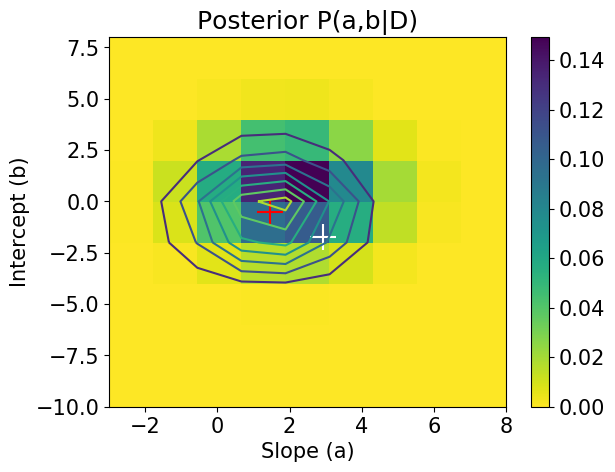

In [51]:
plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(ai, bi, post, cmap=cmap)
plt.contour(ai, bi, post)
fig.colorbar(im, ax=ax0)
plt.scatter(a_ml, b_ml, color='w', marker='+',s=333)
plt.scatter(a_max_post, b_max_post, color='r', marker='+',s=333)
plt.xlabel('Slope (a)')
plt.ylabel('Intercept (b)')
plt.title('Posterior P(a,b|D)')
plt.savefig('ch06_fblr.pdf')

### Calculation of the predictive distribution $p(y|x,(a,b))$ for fixed parameters $a,b$

We now provide a method to calculate the predictive distribution at fixed parameter values.

In [52]:
def pre_distribution(a,b):
    """
        Return the predictive distribution p(y|(a,b)) for a, b
    """
    canvas0 = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
    xi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    yi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    for j,x_ in enumerate(np.linspace(xmin, xmax, nbins_c)):
        py = tfd.Normal(loc=a*x_+b,scale=sigma)
        for i,y_ in enumerate(np.linspace(ymin, ymax, nbins_c)):
            xi[i,j] = x_
            yi[i,j] = y_
            #canvas0[nbins_c-i-1,j] = py.prob(y_)
            canvas0[i,j] = py.prob(y_)
    # This part is a bit tricky. The sum over y for a fixed a should be 1. 
    # However, IMHO due to (more than finite) bin width this is not the case
    # We renormalize
    return canvas0/ np.sum(canvas0,axis=0), xi, yi

### Calculation of the posteriori distribution $p(a,b|D)$

In [53]:
def toBin(a, amin, amax):
    a = np.clip(a, amin, amax)
    return int(0.99999*(a - amin)/(amax-amin) * nbins)

def getProb(a,b):
    return post[toBin(a,amin,amax),toBin(b,bmin,bmax)]

In [54]:
xmin = -10;xmax = +10;ymin=-40;ymax=40;
nbins_c=30
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
pyx = np.zeros((nbins_c, nbins_c), dtype=np.float32) #A 
for a in np.linspace(amin, amax, nbins): #B
    for b in np.linspace(bmin, bmax, nbins):
        p = getProb(a,b) #C
        pyx += pre_distribution(a,b)[0] * getProb(a,b) 
        if (b == bmin):
            print(p)

1.1188686271519242e-10
1.1525268809443806e-09
5.651261366448342e-09
1.3190550323813783e-08
1.4655516987861307e-08
7.751071345698077e-09
1.951392757485144e-09
2.338563559087004e-10
1.3340595063728292e-11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


3.622626744697123e-13


<Figure size 600x600 with 0 Axes>

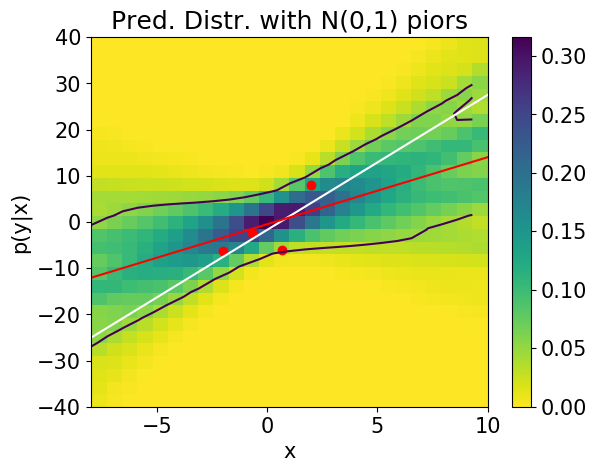

In [55]:
dumm,xi,yi = pre_distribution(a_ml,b_ml)
fig = plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(xi, yi, pyx, cmap=cmap)
plt.contour(xi, yi, pyx,[0.05])
fig.colorbar(im, ax=ax0)
plt.scatter(x,y, marker='o',c='r')

plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='w', alpha = 1)
plt.plot([xmin, xmax], [a_max_post*xmin+b_max_post, a_max_post*xmax+b_max_post], color='r', alpha = 1)

plt.xlim((xmin+2,xmax)) #Strange hack to avoid white space
plt.xlabel('x')
plt.ylabel('p(y|x)')
plt.title('Pred. Distr. with N(0,1) piors')
plt.savefig('ch06_fblr_pd.pdf')

#### Shortcommings of the brute force approach
So we are done. Let's move to networks and fit the 50 million weights. 
Calculating the unnormalized posterior is easy. Done? Wait a moment. In the above example with the two weights we evaluated the unnormalized probability distribution at $\tt{nbins} \times \tt{nbins}$. If we would also fit the sigma parameter that would be $\tt{nbins}^3$ parameters. So a network with 50 million parameters would need $\tt{nbins}^{50 million}$. Let's be satisfied with only $\tt{nbins}=10$. Then we would have $10^{50'000'000}$. If you could do one billion evaluations per second, that would be still take you $10^{50'000'000}/10^9 = 10^{49'999'991}$ seconds. Even for a small network with 100 weights that would take $10^{100}/10^9 = 10^{91}$ seconds. Fun fact go type `10^100 / 10^9 seconds` into [Wolfram Alpha](https://www.wolframalpha.com/input/?i=10%5E100+%2F+10%5E9+seconds). Solution it will take $3.169 \cdot 10^{83}$ years about 10 billion times longer than the age of the univers! [Forget it Ming!](https://getyarn.io/yarn-clip/ecb8c167-324e-4532-9a96-6b0b958fbe52)

This brute force approach does not do the trick for Bayesian Neural Networks. What next? There is an approach called Markov Chain Monte Carlo MCMC for short. It will work for small problems say 10-100 weights but not for large networks. 

### Variational Method
The Markov Chain Monte Carlo Method is still too slow. One fix is not randomly jump around in the high dimensional space but to be quided. There is many research on that (Hamiltonian, No-UTurn Sample XXXsomebody with knowlegde please add).
Another trick, used especially for Neural Networks is Variational Bayes. 

### Variational inference by hand

We now calculate the variational inference "by hand" i.e. without using Keras layers. 

The Variational Inference involves the calculation of the KL Divergence between.

$$
KL(p(q|\theta) || P(w)) 
$$
We model the posterior with 2 independent Gaussians. 

For Gaussians with $N(0,1)$ priors, we can calculate this as (see Kingma Welling 2013 VAE paper in the appendix)
$$
    KL(q(\mu_1|\sigma_1) || N(0,1)) = -\frac{1}{2}  (1 + log(\sigma^2) - \mu^2 - \sigma^2) 
$$

We can check this result by using TFP/ 

In [56]:
mu = 2.
s  = 3.
print(tfd.Normal(2, 3).kl_divergence(tfd.Normal(0, 1)))
-(1. + np.log(s**2) - mu**2 - s**2)/2.

tf.Tensor(4.9013877, shape=(), dtype=float32)


4.90138771133189

We use one vector of size 4 to encode the variational parameters. Foreach Gaussian we model $\mu$ and $\sigma = \tt{softplus(\rho)}$. The softplus ensures that, we do not get negative values for $\sigma$. 

We further imply the reparameterization trick (for backpropagation) and write

$$
 q(b) = N(\mu_b, \sigma_b) = \mu_b + \sigma_b \cdot \epsilon \; \; \epsilon \thicksim N(0,1)  
$$

Don't trust this? We can try to write
$N(2,3)=2+3 \cdot N(0,1)$

Normal (2,3) mu =  2.0  sdtdev =  3.0


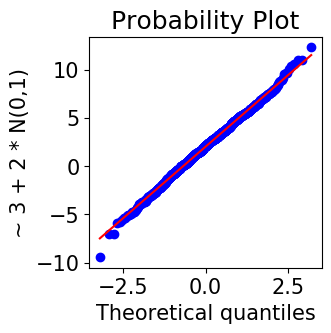

(2.001256, 2.964035)

In [57]:
# Verification with sampling
n23 = tfd.Normal(2,3)
print('Normal (2,3) mu = ',n23.mean().numpy(),' sdtdev = ',n23.stddev().numpy())
fig = plt.figure(figsize=(3,3))
import scipy.stats as stats
n23_rep_sample = 2. + 3. * tfd.Normal(0,1).sample(1000)
stats.probplot(n23_rep_sample, dist="norm", plot=plt) 
plt.ylabel("~ 3 + 2 * N(0,1)")
plt.show()
np.mean(n23_rep_sample), np.std(n23_rep_sample)

In [58]:
# Side note: You cannot calculate and have a distribution. 
# n23_rep = 2. + 3. * tfd.Normal(0,1) 
# But you can use a Bijector to go from one distribution to another 
tfb = tfp.bijectors
base = tfd.Normal(0,1)
bijector = tfp.bijectors.AffineScalar(shift=2, scale=3)
dist = tfd.TransformedDistribution(distribution=base, bijector=bijector)
dist.mean()

<tf.Tensor: id=7194164, shape=(), dtype=float32, numpy=2.0>

In [59]:
## Convenience function to write out weights
class Logger:
    """
        Writes out the weights, gradient, and losses. To be used later in e.g. R. n is the numbver of weights
    """  
    def __init__(self, steps, num_weights = 4):
        self.steps = steps
        self.num_weights = num_weights
        self.X = np.zeros((steps, 12))
        self.header = 'epoch,w0,w1,w2,w3,wg0,wg1,wg2,wg3,loss,loss_kl,loss_mse'
        
    def log(self, step, epoch, w, w_grad, loss, loss_kl, loss_mse):
        n = self.num_weights
        self.X[step,0] = epoch
        self.X[step,1:(n+1)] = w.numpy()
        self.X[step,(n+1):((2*n)+1)] = w_grad.numpy()
        self.X[step,((2*n)+1)] = loss.numpy()
        self.X[step,((2*n)+2)] = loss_kl.numpy()
        self.X[step,((2*n)+3)] = loss_mse.numpy()
        
    def write4r(self, filename):
        np.savetxt(filename, self.X, delimiter=',', header=self.header,comments="",fmt='%.4e');
        
    def getX(self):
        return self.X

In [78]:
from tensorflow.math import log 
epochs=10000
logger = Logger(epochs)
lr = 0.001
optimizer = tf.keras.optimizers.Adam(lr)

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
w_0=(1.,1.,1.,1.)  #A 
w = tf.Variable(w_0)   
e = tfd.Normal(loc=0., scale=1.) #B 
for i in range(epochs):
    with tf.GradientTape() as tape: 
        
        mu_a = w[0] #C
        sigma_a = tf.math.softplus(w[1]) #D
        
        mu_b= w[2]  #E 
        sigma_b= tf.math.softplus(w[3]) #F 
            
        loss_kl = -0.5*(1.0 + log(sigma_a**2) - sigma_a**2 - mu_a**2 + #G
                        1.0 + log(sigma_b**2) - sigma_b**2 - mu_b**2)
       
        a =  mu_a + sigma_a * e.sample()  #H
        b =  mu_b + sigma_b * e.sample()  #I
        
        y_prob = tfd.Normal(loc=x*a+b, scale=sigma)
        loss_nll = -tf.reduce_sum(y_prob.log_prob(ytensor)) #J
       
        loss = loss_nll + loss_kl
    grads = tape.gradient(loss, w) 
    #optimizer.apply_gradients([grads,w]) TODO MAKE working
    w = tf.Variable(w - lr*grads)  # G
    

#A The initial condition of the weight vector w
#B The noise term, needed for the variational trick
#C This controls the center of parameter a 
#D This controls the spread of parameter a
#E This controls the center of b 
#F Control of spread of b
#G KL-Divergence with Gaussian Priors 
#H Sample a ~ N(mu_a, sigma_a) with reparametrization trick
#I Sample b ~ N(mu_b, sigma_b)
#J Calculation of the NLL
#G Gradient Descent step

    logger.log(i, i, w, grads, loss, loss_kl, loss_nll)
    if i % 500 == 0:
        print(i, " loss ", loss.numpy(), " lr ", lr)
        print('a_mu', w[0].numpy(),'b_mu', w[2].numpy())

0  loss  16.589312  lr  0.001
a_mu 1.0014689 b_mu 0.9980229
500  loss  13.943406  lr  0.001
a_mu 1.2716031 b_mu 0.21598093
1000  loss  13.419189  lr  0.001
a_mu 1.3721789 b_mu -0.16076805
1500  loss  16.462343  lr  0.001
a_mu 1.418994 b_mu -0.35365158
2000  loss  15.475619  lr  0.001
a_mu 1.4390007 b_mu -0.45851484
2500  loss  13.171272  lr  0.001
a_mu 1.4593556 b_mu -0.49771157
3000  loss  13.848898  lr  0.001
a_mu 1.4594045 b_mu -0.51206994
3500  loss  14.738081  lr  0.001
a_mu 1.4450759 b_mu -0.5190426
4000  loss  13.960449  lr  0.001
a_mu 1.4373217 b_mu -0.52971816
4500  loss  12.967105  lr  0.001
a_mu 1.4656031 b_mu -0.5252504
5000  loss  13.225329  lr  0.001
a_mu 1.4495934 b_mu -0.5328402
5500  loss  15.953065  lr  0.001
a_mu 1.4545343 b_mu -0.53062284
6000  loss  13.87748  lr  0.001
a_mu 1.4602149 b_mu -0.53015935
6500  loss  14.106572  lr  0.001
a_mu 1.4583993 b_mu -0.53638244
7000  loss  14.212896  lr  0.001
a_mu 1.4454707 b_mu -0.5331975
7500  loss  13.459823  lr  0.001
a_mu 

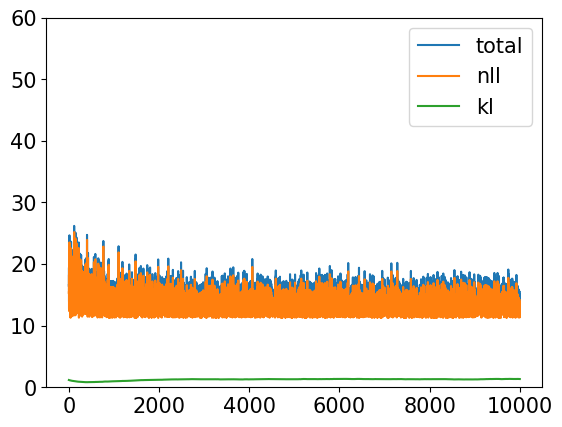

b =  1.6654168   0.7095157  a =  -0.54986656   0.8166313


In [79]:
W = logger.getX()
loss_history = W[:,9]
loss_history_nll = W[:,10]
loss_history_kl = W[:,11]
plt.plot(loss_history)
plt.plot(loss_history_kl)
plt.plot(loss_history_nll)
plt.legend(('total', 'nll', 'kl'))
plt.ylim(0,60)
plt.show()
print('b = ', tf.math.softplus(w[0]).numpy(), ' ', tf.math.softplus(w[1]).numpy(), 
      ' a = ', w[2].numpy(), ' ',  tf.math.softplus(w[3]).numpy())

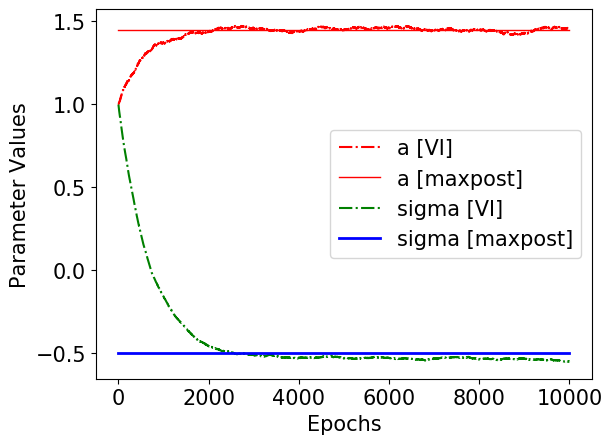

In [101]:
W = logger.getX()
weights = W[:,1:5]
epochs = W.shape[0]
from matplotlib.pyplot import figure

#slope a
plt.plot(weights[:,0],color='r',linestyle='-.')
plt.plot([0, epochs], [a_max_post, a_max_post], linewidth=1,color='r', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Parameter Values')

plt.plot(weights[:,2],color='g', linestyle='-.')
plt.plot([0, epochs], [b_max_post, b_max_post], linewidth=2, color='b', linestyle='-')
plt.legend(('a [VI]', 'a [maxpost]', 'sigma [VI]','sigma [maxpost]'))

plt.savefig('ch08_lr.pdf')   # no plt.show() in previous line! 

In [102]:
logger.write4r('vi.csv')

### Comparing with TFP

We compare against TFP

In [67]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

#123456789012345678901234567890123456789012345678901234
def NLL(y, distr):#C
    return -distr.log_prob(y) 
    
def my_dist(mu): #C
    return tfd.Normal(loc=mu[:,0:1], scale=sigma)

divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0) #B


model = tf.keras.Sequential([
    tfp.layers.DenseReparameterization(1,
       kernel_divergence_fn=divergence_fn,
       bias_divergence_fn=divergence_fn, #A
       bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,#A
       bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn()#A
                                       ),
    tfp.layers.DistributionLambda(my_dist)
])


sgd = tf.keras.optimizers.SGD(lr=.005)
model.compile(loss=NLL, optimizer=sgd)

# A note that TFP usually does not assume distributions on the bias, we overwrite this here. 
# B Rescaling KL-divergence term. Kind of Bug fix for TFP
# C The usual NLL loss for a Gaussian Distribution with fixed variance 

Text(0, 0.5, 'Total loss')

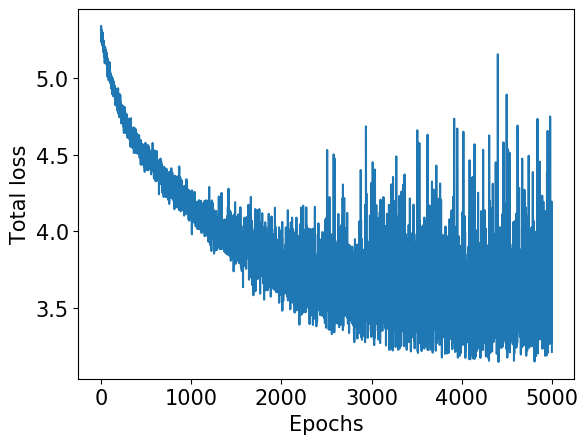

In [68]:
hist = model.fit(x, y, epochs=5000, batch_size=num, verbose=False)
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Total loss')

In [85]:
# print("Loss handwritten ", np.min((loss_history[-100:] / num)), 
#       "TF ", np.min(hist.history['loss'][-100:]))
import pandas as pd
def sp(x):
    return np.log(1 + np.exp(x))**2

wtfp = model.get_weights()
ww = w.numpy()
pd.DataFrame({
    'TFP ':[wtfp[0][0,0], sp(wtfp[1][[0]])[0,0],wtfp[2][0], sp(wtfp[3][[0]])[0]], 
    'VI Manual ': [ww[0], ww[1], ww[2], ww[3]], 
    'MaxPost':[a_max_post, '-', b_max_post, '-'],
    'MaxLike':[a_ml[0], '-', b_ml, '-'] 
    }, 
    index=['a_loc','a_var','b_loc','b_var']
)

,TFP,VI Manual,MaxPost,MaxLike
a_loc,1.468683,1.455792,1.45009,2.92051
a_var,0.473327,0.032473,-,-
b_loc,-0.532946,-0.549867,-0.49911,-1.72671
b_var,0.654345,0.233382,-,-
